# Graph Neural Networks (GNN)

Graph Neural Network {cite}`scarselli_gori_tsoi_hagenbuchner_monfardini_2009` is a type of neural Network which directly operates on the graph structure. In GNN, graph nodes represent objects or concepts, and edges represent their relationships. Each concept is naturally defined by its features and the related concepts. Thus, we can attach a hidden **state** $x_n \in R^s$ to each node $n$ that is based on the information contained in the neighborhood of $n$. The following figure illustrated the embedding process of each node using local transition and local output functions.

![](../../images/Learn2Search/GNN_1.png)

where $l_n,l_{co[n]},x_{ne[n]}$ and $l_{ne[n]}$ are the label of $n$, the labels of its edges, the states, and the labels of the nodes in the neighborhood of $n$, respectively.
$x,o,l$ and $l_N$ are the vectors constructed by stacking all the states, all the outputs, all the labels, and all the node labels, respectively as illustrated below.

![](../../images/Learn2Search/GNN_2.png)

The following figure summarizes the GNN-based embedding process {cite}`DBLP:journals/corr/abs-1906-01227`.

![](../../images/Learn2Search/GNN_3.png)

GNN is used in several smart mobility applications. For example, the accuracy of real time ETAs was improved by up to 50% in places like Berlin, Jakarta, São Paulo, Sydney, Tokyo, and Washington D.C. by using advanced machine learning techniques including Graph Neural Networks, such as [DeepMind](https://deepmind.com/blog/article/traffic-prediction-with-advanced-graph-neural-networks).

## Graph Convolutional Neural Network (GCNs)

In a graph convolutional neural network, embedding can take the following form:<br><br>
$h^k_v=f(W_k \sum\limits_{u \in N(j)} \frac{1}{|N(v)|} h^{k-1}_u + B_k h^{k-1}_v), \forall k \in \{1,...,K\}$ <br><br>
where<br><br>
$h_v^k$ is node $v$ embedding after $k$ layers of neighbourhood aggregation<br><br>
$\sum\limits_{u \in N(j)} \frac{1}{|N(v)|} h^{k-1}_u$ are neighbors’ representations (average of neighbor’s previous layer embeddings)<br><br>
$B_k h^{k-1}_v$ represent own representation of node $v$ in previous layer $k-1$<br><br>
$f$ is a non-linearity function such as ReLU.

## Using GCN to solve TSP

GCNs can also be used to predict "likely" edges that would appear in a solution to TSP. These likely edges can then be run through a beam search to look for near-optimal solutions.

This example will use code adapted from [this paper](https://arxiv.org/abs/1906.01227).

### Import dependencies

In [1]:
# Some initial setup
import os
import json
import argparse
import time
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from tensorboardX import SummaryWriter
from fastprogress import master_bar, progress_bar

# Remove warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

from graph_convnet.config import *
from graph_convnet.utils.graph_utils import *
from graph_convnet.utils.google_tsp_reader import GoogleTSPReader
from graph_convnet.utils.plot_utils import *
from graph_convnet.models.gcn_model import ResidualGatedGCNModel
from graph_convnet.utils.model_utils import *

### Enable Notebook mode for Jupyter Notebook

In [2]:
notebook_mode = True
viz_mode = False

if notebook_mode == True:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('png')

/tmp/ipykernel_12208/970473254.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


### Load TSP20 Configuration Files

In [3]:
config_path = "graph_convnet/configs/tsp20.json"
config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))

Loaded graph_convnet/configs/tsp20.json:
{'expt_name': 'tsp20', 'gpu_id': '1', 'train_filepath': 'graph_convnet/data/tsp20_train_concorde.txt', 'val_filepath': 'graph_convnet/data/tsp20_val_concorde.txt', 'test_filepath': 'graph_convnet/data/tsp20_test_concorde.txt', 'num_nodes': 20, 'num_neighbors': -1, 'node_dim': 2, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 1280, 'hidden_dim': 300, 'num_layers': 30, 'mlp_layers': 3, 'aggregation': 'mean', 'max_epochs': 1500, 'val_every': 5, 'test_every': 100, 'batch_size': 20, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01}


### Setup GPU and CUDA

In [13]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.gpu_id)  

if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)


CUDA not available


### Setup Network and parameters

In [14]:
if notebook_mode == True:
    # Instantiate the network
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)
    
    # Define optimizer
    learning_rate = config.learning_rate
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)

Number of parameters: 11054402
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


### Load Previous Training Checkpoint

In [6]:
if notebook_mode==True:
    # Load checkpoint
    log_dir = f"graph_convnet/logs/{config.expt_name}/"
    if torch.cuda.is_available():
        checkpoint = torch.load(log_dir+"best_val_checkpoint.tar")
    else:
        checkpoint = torch.load(log_dir+"best_val_checkpoint.tar", map_location='cpu')
    # Load network state
    net.load_state_dict(checkpoint['model_state_dict'])
    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # Load other training parameters
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']
    for param_group in optimizer.param_groups:
        learning_rate = param_group['lr']
    print(f"Loaded checkpoint from epoch {epoch}")    



Loaded checkpoint from epoch 1455


#### Function to convert metrics to text

In [7]:
def metrics_to_str(epoch, time, learning_rate, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len):
    result = ( 'epoch:{epoch:0>2d}\t'
               'time:{time:.1f}h\t'
               'lr:{learning_rate:.2e}\t'
               'loss:{loss:.4f}\t'
               # 'err_edges:{err_edges:.2f}\t'
               # 'err_tour:{err_tour:.2f}\t'
               # 'err_tsp:{err_tsp:.2f}\t'
               'pred_tour_len:{pred_tour_len:.3f}\t'
               'gt_tour_len:{gt_tour_len:.3f}'.format(
                   epoch=epoch,
                   time=time/3600,
                   learning_rate=learning_rate,
                   loss=loss,
                   # err_edges=err_edges,
                   # err_tour=err_tour,
                   # err_tsp=err_tsp,
                   pred_tour_len=pred_tour_len,
                   gt_tour_len=gt_tour_len))
    return result


#### Function to run test data

In [8]:
def test(net, config, master_bar, mode='test'):
    # Set evaluation mode
    net.eval()

    # Assign parameters
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    beam_size = config.beam_size
    val_filepath = config.val_filepath
    test_filepath = config.test_filepath

    # Load TSP data
    if mode == 'val':
        dataset = GoogleTSPReader(num_nodes, num_neighbors, batch_size=batch_size, filepath=val_filepath)
    elif mode == 'test':
        dataset = GoogleTSPReader(num_nodes, num_neighbors, batch_size=batch_size, filepath=test_filepath)
    batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    # running_err_edges = 0.0
    # running_err_tour = 0.0
    # running_err_tsp = 0.0
    running_pred_tour_len = 0.0
    running_gt_tour_len = 0.0
    running_nb_data = 0
    running_nb_batch = 0
    
    with torch.no_grad():
        start_test = time.time()
        for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
            # Generate a batch of TSPs
            try:
                batch = next(dataset)
            except StopIteration:
                break

            # Convert batch to torch Variables
            x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
            x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
            x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
            x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
            y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
            y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
            
            # Compute class weights (if uncomputed)
            if type(edge_cw) != torch.Tensor:
                edge_labels = y_edges.cpu().numpy().flatten()
                edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

            # Forward pass
            y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
            loss = loss.mean()  # Take mean of loss across multiple GPUs

            # Compute error metrics
            # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)

            # Get batch beamsearch tour prediction
            if mode == 'val':  # Validation: faster 'vanilla' beamsearch
                bs_nodes = beamsearch_tour_nodes(
                    y_preds, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
            elif mode == 'test':  # Testing: beamsearch with shortest tour heuristic 
                bs_nodes = beamsearch_tour_nodes_shortest(
                    y_preds, x_edges_values, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
            
            # Compute mean tour length
            pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
            gt_tour_len = np.mean(batch.tour_len)

            # Update running data
            running_nb_data += batch_size
            running_loss += batch_size* loss.data.item()
            # running_err_edges += batch_size* err_edges
            # running_err_tour += batch_size* err_tour
            # running_err_tsp += batch_size* err_tsp
            running_pred_tour_len += batch_size* pred_tour_len
            running_gt_tour_len += batch_size* gt_tour_len
            running_nb_batch += 1

            # Log intermediate statistics
            result = ('loss:{loss:.4f} pred_tour_len:{pred_tour_len:.3f} gt_tour_len:{gt_tour_len:.3f}'.format(
                loss=running_loss/running_nb_data,
                pred_tour_len=running_pred_tour_len/running_nb_data,
                gt_tour_len=running_gt_tour_len/running_nb_data))
            master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    pred_tour_len = running_pred_tour_len/ running_nb_data
    gt_tour_len = running_gt_tour_len/ running_nb_data

    return time.time()-start_test, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len

### Test model on randomly generated graphs

Class weights: [0.55555556 5.        ]
Predicted tour length: 3.522 (mean)
Groundtruth tour length: 3.522 (mean)


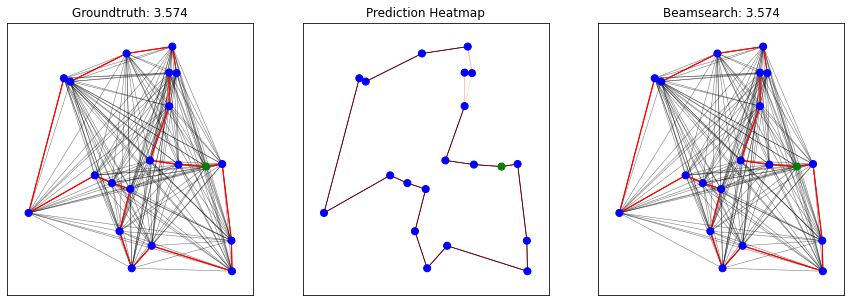

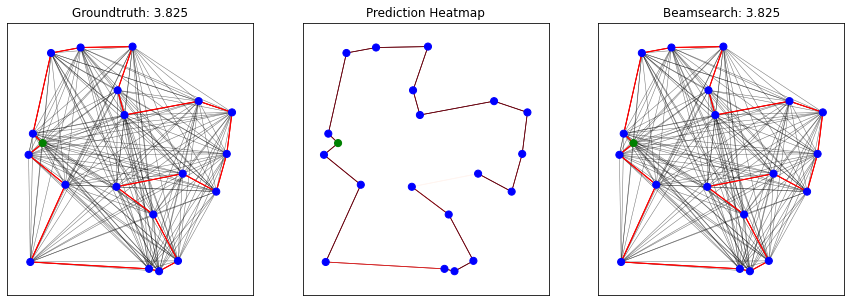

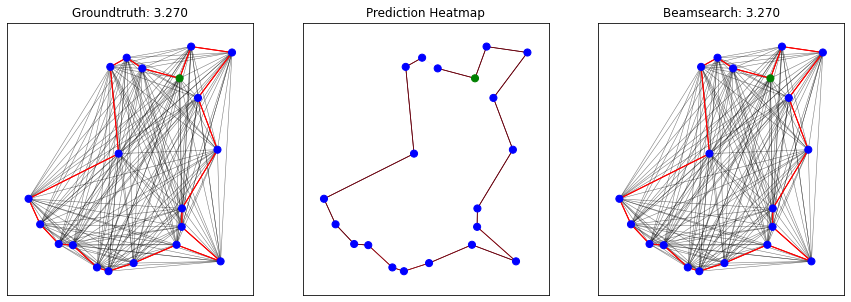

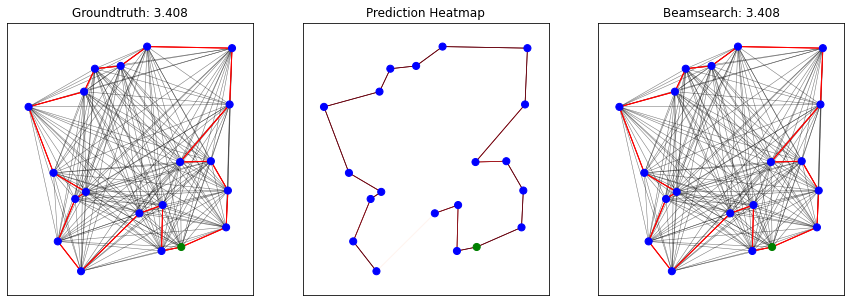

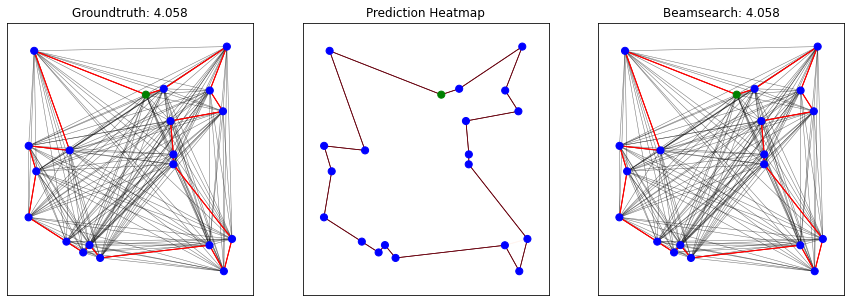

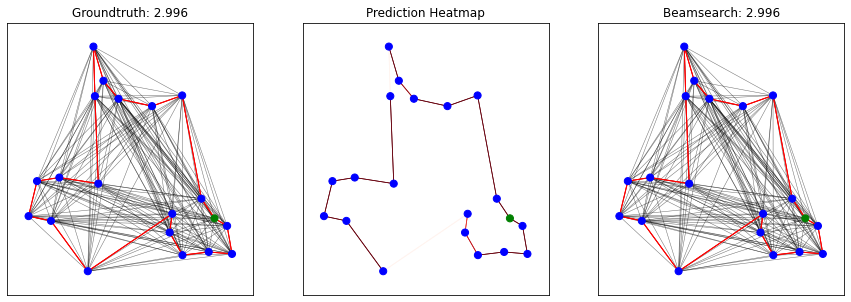

In [12]:
if notebook_mode==True:
    # Set evaluation mode
    net.eval()
    
    batch_size = 3
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    beam_size = config.beam_size
    test_filepath = config.test_filepath
    dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, batch_size, test_filepath))
    batch = next(dataset)

    with torch.no_grad():
        # Convert batch to torch Variables
        x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
        x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
        x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
        
        # Compute class weights
        edge_labels = y_edges.cpu().numpy().flatten()
        edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        print("Class weights: {}".format(edge_cw))
        
        # Forward pass
        y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
        loss = loss.mean()
        
        # Get batch beamsearch tour prediction
        bs_nodes = beamsearch_tour_nodes_shortest(
            y_preds, x_edges_values, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
        #bs_nodes = beamsearch_tour_nodes(
        #    y_preds, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')

        # Compute mean tour length
        pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
        gt_tour_len = np.mean(batch.tour_len)
        print("Predicted tour length: {:.3f} (mean)\nGroundtruth tour length: {:.3f} (mean)".format(pred_tour_len, gt_tour_len))

        # Sanity check
        for idx, nodes in enumerate(bs_nodes):
            if not is_valid_tour(nodes, num_nodes):
                print(idx, " Invalid tour: ", nodes)

        # Plot prediction visualizations
        plot_predictions_beamsearch(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds, bs_nodes, num_plots=batch_size)

## Resources:
- [Graph Convolutional Network Technique for the Travelling Salesman Problem](https://github.com/chaitjo/graph-convnet-tsp)
- A library for graph neural networks in jax ([Jraph](https://github.com/deepmind/jraph))
- Deep Graph Library ([DGL](https://github.com/dmlc/dgl))
- Graph Nets Library ([Graph Nets](https://github.com/deepmind/graph_nets))
- PyTorch Geometric Library ([PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/))
- Stanford Network Analysis Platform ([SNAP](https://github.com/snap-stanford/snap-python))